## Building a Deep Face Detection Model

### 1. Setup and Get Data

#### 1.1 Install Dependencies and Setup

In [1]:
# !pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

#### 1.2 Collect Images Using OpenCV 

In [2]:
import cv2 
import os
import time
import uuid

In [3]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 20

In [4]:
# cap = cv2.VideoCapture(0)
# for imgnum in range(number_images):
#     print("Collecting image {}".format(imgnum))
#     ret, frame = cap.read()
#     imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
#     cv2.imwrite(imgname, frame)
#     cv2.imshow('frame', frame)
#     time.sleep(0.5)

#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()

#### 1.3 Annotate Images with LabelMe

In [5]:
# !labelme

### 2. Review Dataset and Build Image Loading Function

#### 2.1 Import TF and Deps

In [6]:
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

2025-07-30 15:07:27.611115: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### 2.2 Limit GPU Memory Growth

In [7]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
tf.config.list_physical_devices('GPU')

[]

#### 2.3 Load Image into TF Data Pipeline

In [9]:
images = tf.data.Dataset.list_files('data/train/images/*.jpg', shuffle=False)

2025-07-30 15:07:30.061182: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [10]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [11]:
images = images.map(load_image)

In [12]:
images.as_numpy_iterator().next()

2025-07-30 15:07:30.192972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [28]
	 [[{{node Placeholder/_0}}]]


array([[[16, 23, 15],
        [17, 24, 16],
        [16, 23, 15],
        ...,
        [ 0,  2,  0],
        [ 0,  3,  0],
        [ 0,  3,  0]],

       [[16, 23, 15],
        [16, 23, 15],
        [15, 22, 14],
        ...,
        [ 0,  3,  0],
        [ 0,  3,  0],
        [ 0,  3,  0]],

       [[14, 21, 13],
        [14, 21, 13],
        [13, 20, 12],
        ...,
        [ 0,  4,  0],
        [ 0,  3,  0],
        [ 0,  3,  0]],

       ...,

       [[26, 21,  1],
        [26, 21,  1],
        [26, 21,  1],
        ...,
        [ 0,  4,  3],
        [ 0,  4,  3],
        [ 0,  4,  3]],

       [[26, 21,  1],
        [26, 21,  1],
        [26, 21,  1],
        ...,
        [ 0,  4,  3],
        [ 0,  4,  3],
        [ 0,  4,  3]],

       [[26, 21,  1],
        [26, 21,  1],
        [26, 21,  1],
        ...,
        [ 0,  4,  3],
        [ 0,  4,  3],
        [ 0,  4,  3]]], dtype=uint8)

#### 2.4 View Raw Images with Matplotlib

In [13]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [14]:
image_generator = images.batch(4).as_numpy_iterator()

2025-07-30 15:07:30.251197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [28]
	 [[{{node Placeholder/_0}}]]


In [15]:
plot_images = image_generator.next()

In [16]:
plot_images.shape  # Each image is 480px high and 640px wide

(4, 480, 640, 3)

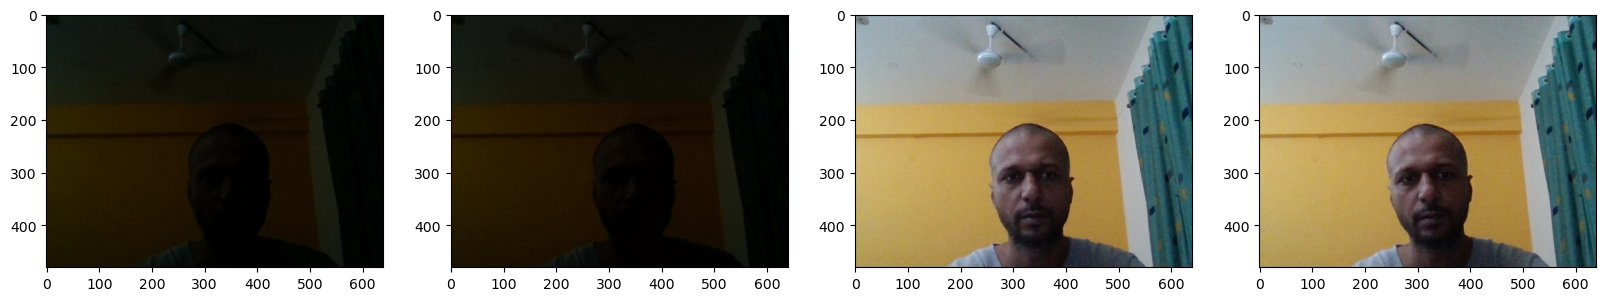

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

### 3. Partition Unaugmented Data

#### 3.1 Manually split data into train, test and val

In [18]:
40*0.7 # 70% to train

28.0

In [19]:
40*0.15 # 15% to test and val

6.0

#### 3.2 Move the Matching Labels

In [20]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

### 4. Apply Image Augmentation on Images and Labels using Albumentations

#### 4.1 Setup Albumentations Transform Pipeline

In [21]:
import albumentations as alb

In [22]:
cv2.imread('data/train/images/3bb7b270-6c81-11f0-9d10-e8fb1c91fa69.jpg').shape # 480px high, 640px wide, 3 channels

(480, 640, 3)

In [23]:
augmentor = alb.Compose([
    alb.RandomCrop(width=450, height=450),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)],
    bbox_params=alb.BboxParams(format='albumentations', 
                               label_fields=['class_labels'])
)

#### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [24]:
img = cv2.imread(os.path.join('data', 'train', 'images', '3bb7b270-6c81-11f0-9d10-e8fb1c91fa69.jpg'))

In [25]:
with open(os.path.join('data', 'train', 'labels', '3bb7b270-6c81-11f0-9d10-e8fb1c91fa69.json'), 'r') as f:
    label = json.load(f)

In [26]:
label

{'version': '5.2.1',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[258.75, 198.75], [441.25, 456.25]],
   'group_id': None,
   'description': '',
   'shape_type': 'rectangle',
   'flags': {}}],
 'imagePath': '../images/3bb7b270-6c81-11f0-9d10-e8fb1c91fa69.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQgJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dX

In [27]:
label['shapes'][0]['label'], label['shapes'][0]['points']

('face', [[258.75, 198.75], [441.25, 456.25]])

#### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [28]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [29]:
coords

[258.75, 198.75, 441.25, 456.25]

In [30]:
coords = list(np.divide(coords, [640, 480, 640, 480]))

In [31]:
coords

[0.404296875, 0.4140625, 0.689453125, 0.9505208333333334]

#### 4.4 Apply Augmentations and View Results

In [32]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [33]:
augmented

{'image': array([[[16, 21, 19],
         [16, 21, 19],
         [16, 21, 19],
         ...,
         [ 3,  4,  0],
         [ 4,  5,  1],
         [ 4,  5,  1]],
 
        [[16, 21, 19],
         [16, 21, 19],
         [16, 21, 19],
         ...,
         [ 4,  5,  1],
         [ 4,  5,  1],
         [ 3,  4,  0]],
 
        [[16, 21, 19],
         [16, 21, 19],
         [16, 21, 19],
         ...,
         [ 5,  6,  2],
         [ 3,  4,  0],
         [ 3,  4,  0]],
 
        ...,
 
        [[ 1, 18, 27],
         [ 1, 18, 27],
         [ 0, 17, 26],
         ...,
         [ 2,  3,  0],
         [ 2,  3,  0],
         [ 2,  3,  1]],
 
        [[ 1, 18, 27],
         [ 0, 17, 26],
         [ 0, 17, 26],
         ...,
         [ 3,  4,  0],
         [ 2,  3,  0],
         [ 2,  3,  1]],
 
        [[ 0, 18, 25],
         [ 0, 16, 25],
         [ 0, 16, 25],
         ...,
         [ 3,  4,  0],
         [ 2,  3,  0],
         [ 2,  3,  1]]], dtype=uint8),
 'bboxes': [(0.22611111111111112,

In [34]:
augmented['image'].shape

(450, 450, 3)

In [35]:
augmented['bboxes']

[(0.22611111111111112,
  0.3794444444444444,
  0.6316666666666667,
  0.9516666666666667)]

In [36]:
augmented['class_labels'][0]

'face'

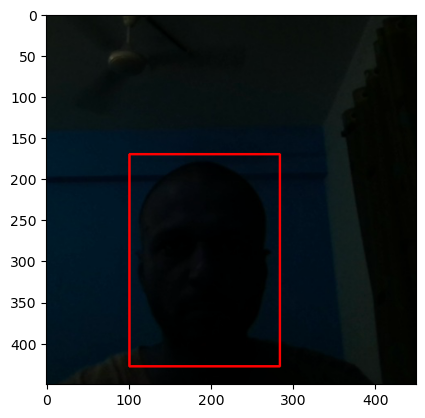

In [37]:
# Visualization
cv2.rectangle(augmented['image'],
             tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),  # top most coordinate
             tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)),  # bottom most coordinate
             (255,0,0), 2)
plt.imshow(augmented['image'])

### 5. Build and Run Augmentation Pipeline

#### 5.1 Run Augmentation Pipeline

In [38]:
for partition in ['train', 'test', 'val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001, 0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640, 480, 640, 480]))
        try:
            for x in range(30):  # Creating 30 augmented images for each image
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])
                annotation = {}
                annotation['image'] = image
                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0

                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

#### 5.2 Load Augmented Images to Tensorflow Dataset

In [39]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x/255)

In [40]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x/255)

In [41]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x/255)

In [42]:
train_images.as_numpy_iterator().next()

2025-07-30 15:07:42.269961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [840]
	 [[{{node Placeholder/_0}}]]


array([[[0.14172794, 0.15692402, 0.14270833],
        [0.14080882, 0.15508579, 0.14117648],
        [0.14491421, 0.15275735, 0.14099264],
        ...,
        [0.22794117, 0.21323529, 0.13725491],
        [0.22175245, 0.21090686, 0.13363971],
        [0.23180147, 0.21568628, 0.13762255]],

       [[0.14558823, 0.15245098, 0.14117648],
        [0.1420956 , 0.14908089, 0.1377451 ],
        [0.14601716, 0.1538603 , 0.1420956 ],
        ...,
        [0.23186274, 0.2112745 , 0.13333334],
        [0.2314951 , 0.21176471, 0.13339461],
        [0.23560049, 0.21537991, 0.13725491]],

       [[0.14656863, 0.14656863, 0.13872549],
        [0.14509805, 0.14607844, 0.1377451 ],
        [0.14166667, 0.1495098 , 0.1377451 ],
        ...,
        [0.23970588, 0.2122549 , 0.1377451 ],
        [0.23535539, 0.20790441, 0.13339461],
        [0.23939951, 0.21194853, 0.13743873]],

       ...,

       [[0.19087009, 0.19871323, 0.17910539],
        [0.1877451 , 0.19705883, 0.17696078],
        [0.18431373, 0

### 6. Prepare Labels

#### 6.1 Build Label Loading Function

In [43]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
    return [label['class']], label['bbox']

#### 6.2 Load Labels to TensorFlow Dataset

In [44]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels.as_numpy_iterator().next()

2025-07-30 15:07:42.337096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [840]
	 [[{{node Placeholder/_0}}]]


b'aug_data/train/labels/3bb7b270-6c81-11f0-9d10-e8fb1c91fa69.0.json'

In [45]:
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
train_labels.as_numpy_iterator().next()

2025-07-30 15:07:42.388426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [840]
	 [[{{node Placeholder/_0}}]]


(array([1], dtype=uint8),
 array([0.2172, 0.0461, 0.6226, 0.618 ], dtype=float16))

In [46]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [47]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

### 7. Combine Label and Image Samples

#### 7.1 Check Partition Lengths

In [48]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(840, 840, 180, 180, 180, 180)

#### 7.2 Create Final Datasets (Images/Labels)

In [49]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(840)
train = train.batch(8)
train = train.prefetch(4)

In [50]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(180)
test = test.batch(8)
test = test.prefetch(4)

In [51]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(180)
val = val.batch(8)
val = val.prefetch(4)

In [52]:
train.as_numpy_iterator().next()[0].shape

2025-07-30 15:07:42.612928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [840]
	 [[{{node Placeholder/_5}}]]
2025-07-30 15:07:42.613330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [840]
	 [[{{node Placeholder/_0}}]]


(8, 120, 120, 3)

In [53]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.3096  , 0.411   , 0.715   , 0.9487  ],
        [0.1927  , 0.035   , 0.693   , 0.618   ],
        [0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      ],
        [0.001079, 0.1057  , 0.4602  , 0.702   ],
        [0.1151  , 0.401   , 0.55    , 0.947   ],
        [0.2573  , 0.0473  , 0.6953  , 0.5933  ],
        [0.3193  , 0.3079  , 0.756   , 0.8896  ]], dtype=float16))

#### 7.3 View Images and Annotations

In [54]:
data_samples = train.as_numpy_iterator()

In [55]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


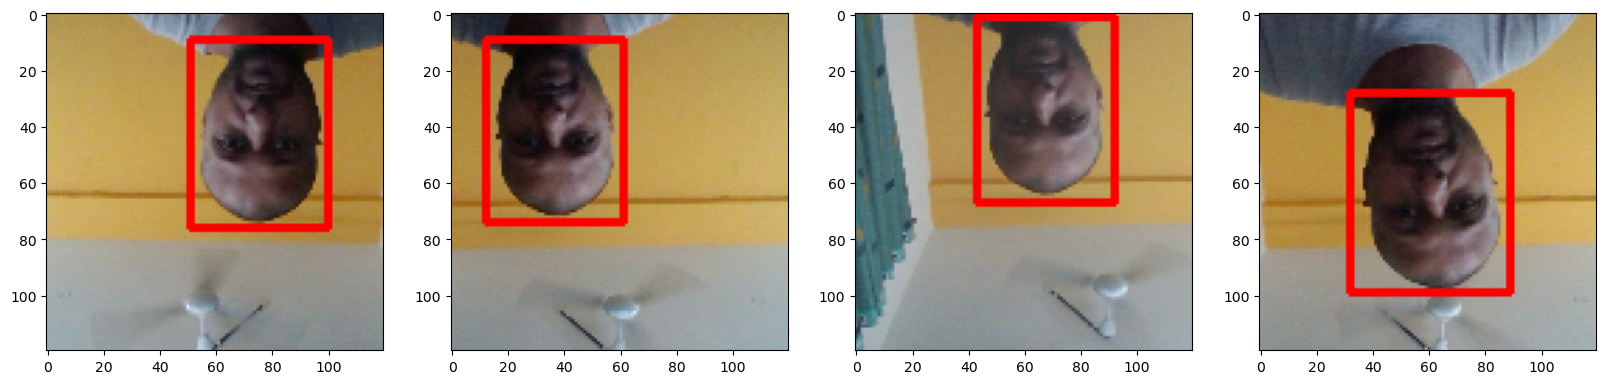

In [56]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                    tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                    tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                    (255,0,0), 2)
    ax[idx].imshow(sample_image)

### 8. Build Deep Learning using the Functional API

#### 8.1 Import Layers and Base Network

In [57]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

#### 8.2 Download VGG16

In [58]:
vgg = VGG16(include_top=False)

In [59]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

#### 8.3 Build instance of Network

In [60]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)
    VGG = VGG16(include_top=False)
    VGG.trainable = False  # <--- This line freezes the VGG16 layers

    vgg = VGG(input_layer)
    
    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(64, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding Box Model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(64, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])

    return facetracker

#### 8.4 Test out Neural Network

In [61]:
facetracker = build_model()

In [62]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [63]:
X, y = train.as_numpy_iterator().next()

In [64]:
X

array([[[[6.82352960e-01, 6.08762264e-01, 2.34375000e-01],
         [6.70281887e-01, 5.87928951e-01, 2.28125006e-01],
         [6.84987724e-01, 6.05575979e-01, 2.44301468e-01],
         ...,
         [1.82352945e-01, 2.33333334e-01, 2.05882356e-01],
         [1.41727939e-01, 1.81433827e-01, 1.46629900e-01],
         [1.49816170e-01, 1.80024505e-01, 1.50183827e-01]],

        [[6.63725495e-01, 5.94607830e-01, 1.97671562e-01],
         [7.00367630e-01, 6.29473031e-01, 2.46568620e-01],
         [6.86580896e-01, 6.22548997e-01, 2.50428915e-01],
         ...,
         [1.67769611e-01, 2.18750000e-01, 1.91299021e-01],
         [1.70465693e-01, 2.10171565e-01, 1.75367653e-01],
         [1.49877444e-01, 1.89093143e-01, 1.56250000e-01]],

        [[6.85477912e-01, 6.22732818e-01, 2.49080881e-01],
         [6.90563738e-01, 6.24387264e-01, 2.62132347e-01],
         [6.76470578e-01, 6.09803915e-01, 2.56740183e-01],
         ...,
         [1.72242641e-01, 2.23223045e-01, 1.95772052e-01],
         [

In [65]:
y

(array([[1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0]], dtype=uint8),
 array([[0.3894 , 0.126  , 0.8745 , 0.739  ],
        [0.4465 , 0.03323, 0.855  , 0.577  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.434  , 0.3977 , 0.8394 , 0.935  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.1361 , 0.4038 , 0.636  , 0.9873 ],
        [0.     , 0.     , 0.     , 0.     ]], dtype=float16))

In [66]:
X.shape

(8, 120, 120, 3)

In [67]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 1s/step


In [68]:
classes

array([[0.17535819],
       [0.24419706],
       [0.1640063 ],
       [0.1753215 ],
       [0.42929706],
       [0.32417947],
       [0.29476842],
       [0.15157193]], dtype=float32)

In [69]:
coords

array([[0.6025906 , 0.63813794, 0.48058015, 0.53679526],
       [0.4506438 , 0.71582556, 0.429426  , 0.46743527],
       [0.5207758 , 0.8361446 , 0.47870964, 0.32574943],
       [0.512695  , 0.75982535, 0.46489304, 0.43665457],
       [0.45892578, 0.81374246, 0.4279234 , 0.3209035 ],
       [0.5970237 , 0.7460276 , 0.4310593 , 0.35471877],
       [0.55881584, 0.6553308 , 0.45326033, 0.48014224],
       [0.4680069 , 0.8120158 , 0.53069067, 0.39460108]], dtype=float32)

### 9. Define Losses and Optimizers

#### 9.1 Define Optimizer and LR

In [70]:
len(train)

105

In [71]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 - 1) / batches_per_epoch

In [72]:
lr_decay

0.0031746031746031737

In [73]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

In [74]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:, :2] - yhat[:, :2]))

    h_true = y_true[:, 3] - y_true[:, 1]
    w_true = y_true[:, 2] - y_true[:, 0]

    h_pred = yhat[:, 3] - yhat[:, 1]
    w_pred = yhat[:, 2] - yhat[:, 0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [75]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

#### 9.3 Test out Loss Metrics

In [76]:
localization_loss(y[1], coords).numpy()

9.403535

In [77]:
classloss(y[0], classes).numpy()

0.7682459

In [78]:
regressloss(y[1], coords).numpy()

9.403535

### 10. Train Neural Network

#### 10.1 Create Custom Model Class

In [79]:
class FaceTracker(Model):
    def __init__(self, eyetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    
    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    
    def train_step(self, batch, **kwargs):
        
        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+0.5*batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total loss ": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}


    def test_step(self, batch, **kwargs):

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}


    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [80]:
model = FaceTracker(facetracker)

In [81]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [82]:
logdir = 'logs'

In [83]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [84]:
hist = model.fit(train, epochs=40, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40
105/105 [==============================] - ETA: 0s - total loss : 2.5640 - class_loss: 0.3892 - regress_loss: 2.3695    

2025-07-30 15:09:41.169976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [180]
	 [[{{node Placeholder/_5}}]]
2025-07-30 15:09:41.170423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [180]
	 [[{{node Placeholder/_5}}]]


105/105 [==============================] - 134s 1s/step - total loss : 2.5514 - class_loss: 0.3875 - regress_loss: 2.3577 - val_total_loss: 2.6172 - val_class_loss: 0.6042 - val_regress_loss: 2.3151
Epoch 2/40
105/105 [==============================] - 147s 1s/step - total loss : 1.1448 - class_loss: 0.2095 - regress_loss: 1.0400 - val_total_loss: 1.9353 - val_class_loss: 0.3961 - val_regress_loss: 1.7373
Epoch 3/40
105/105 [==============================] - 131s 1s/step - total loss : 0.9532 - class_loss: 0.1533 - regress_loss: 0.8766 - val_total_loss: 1.4822 - val_class_loss: 0.2633 - val_regress_loss: 1.3506
Epoch 4/40
105/105 [==============================] - 149s 1s/step - total loss : 0.8408 - class_loss: 0.1202 - regress_loss: 0.7807 - val_total_loss: 1.2917 - val_class_loss: 0.2271 - val_regress_loss: 1.1782
Epoch 5/40
105/105 [==============================] - 149s 1s/step - total loss : 0.7619 - class_loss: 0.0978 - regress_loss: 0.7130 - val_total_loss: 1.1532 - val_class_l

#### 10.3 Plot Performance

In [92]:
hist.history

{'total loss ': [1.2271242141723633,
  1.9713642597198486,
  1.1909843683242798,
  0.6177468299865723,
  0.754286527633667,
  0.7329678535461426,
  0.7221664786338806,
  0.7201461791992188,
  0.8791507482528687,
  0.45452624559402466,
  0.5345788598060608,
  0.37995436787605286,
  0.8565171360969543,
  0.4374847114086151,
  0.2760753631591797,
  0.364432156085968,
  0.5365466475486755,
  0.5713053941726685,
  0.6002110242843628,
  0.4564717411994934,
  0.4395468831062317,
  0.3343999683856964,
  0.17995239794254303,
  0.4978587329387665,
  0.2749532163143158,
  0.2057790458202362,
  0.30062422156333923,
  0.3155137598514557,
  0.44436389207839966,
  0.2107785940170288,
  0.5605089068412781,
  0.29921141266822815,
  0.34254297614097595,
  0.337385892868042,
  0.22190958261489868,
  0.34494373202323914,
  0.24010886251926422,
  0.10811418294906616,
  0.19687238335609436,
  0.3719905912876129],
 'class_loss': [0.20863944292068481,
  0.3564379811286926,
  0.16147206723690033,
  0.093030631

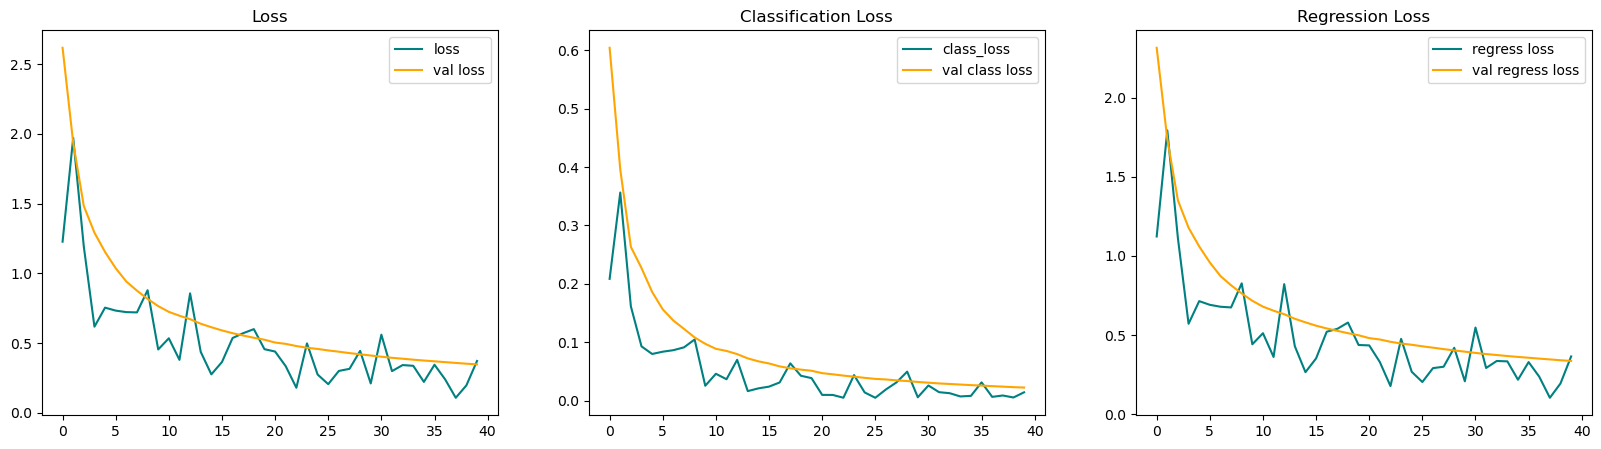

In [93]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 5))

ax[0].plot(hist.history['total loss '], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class_loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

### 11. Make Predictions

#### 11.1 Make Predictions on the Test Set

In [121]:
test_data = test.as_numpy_iterator()

In [122]:
test_sample = test_data.next()

In [123]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


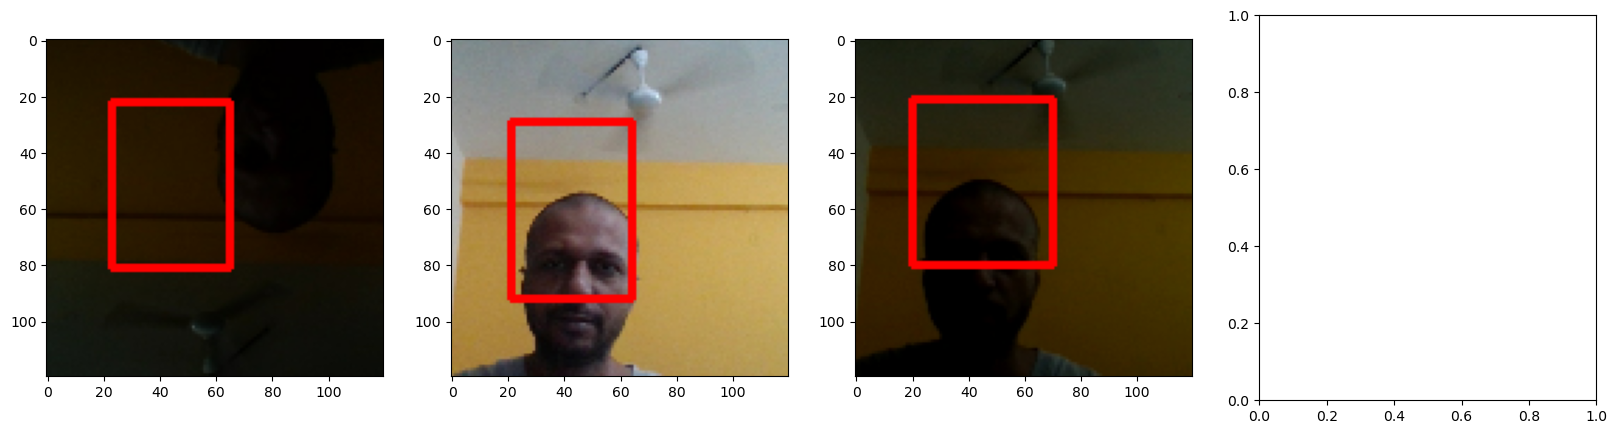

In [126]:
fig, ax  = plt.subplots(ncols=4, figsize=(20,5))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                     tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                     tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                     (255,0,0), 2)
        ax[idx].imshow(sample_image)

#### 11.2 Save the Model

In [127]:
from tensorflow.keras.models import load_model

In [128]:
facetracker.save('facetracker.h5')

In [129]:
facetracker = load_model('facetracker.h5')

#### 11.3 Real Time Face Detection

In [137]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _, frame = cap.read()
    frame = frame[50:500, 50:500, :]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120, 120))

    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]

    if yhat[0] > 0.5:
        # Controls the main rectangle
        cv2.rectangle(frame,
                     tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                     tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)),
                     (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame,
                     tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), [0,-30])),
                     tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), [80,0])),
                     (255,0,0), -1)

        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),[0,-5])),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow('EyeTrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
            
cap.release()
cv2.destroyAllWindows()

[ WARN:0@9597.841] global /croot/opencv-suite_1691620365762/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


1/1 [==============================] - 0s 229ms/step


qt.glx: qglx_findConfig: Failed to finding matching FBConfig for QSurfaceFormat(version 2.0, options QFlags<QSurfaceFormat::FormatOption>(), depthBufferSize -1, redBufferSize 1, greenBufferSize 1, blueBufferSize 1, alphaBufferSize -1, stencilBufferSize -1, samples -1, swapBehavior QSurfaceFormat::SingleBuffer, swapInterval 1, colorSpace QSurfaceFormat::DefaultColorSpace, profile  QSurfaceFormat::NoProfile)
No XVisualInfo for format QSurfaceFormat(version 2.0, options QFlags<QSurfaceFormat::FormatOption>(), depthBufferSize -1, redBufferSize 1, greenBufferSize 1, blueBufferSize 1, alphaBufferSize -1, stencilBufferSize -1, samples -1, swapBehavior QSurfaceFormat::SingleBuffer, swapInterval 1, colorSpace QSurfaceFormat::DefaultColorSpace, profile  QSurfaceFormat::NoProfile)
Falling back to using screens root_visual.


1/1 [==============================] - 0s 205ms/step
